In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [4]:
def factor(df, window = 96):
    """
    ËÆ°ÁÆóÊûÅÁ´ØÊî∂ÁõäÁéáÂèçËΩ¨Âõ†Â≠ê(ERRÂõ†Â≠ê)
    Ê≠•È™§:
    1. ËÆ°ÁÆóÊØèÊ†πKÁ∫øÁöÑÊî∂ÁõäÁéá
    2. ÊåâËá™ÁÑ∂Êó•ÂàÜÁªÑÔºåÊâæÂá∫ÊØèÊó•ÊúÄÊûÅÁ´ØÊî∂ÁõäÁöÑKÁ∫ø
    3. ËÆ°ÁÆóÊúÄÊûÅÁ´ØÊî∂ÁõäÂèäÂÖ∂Ââç‰∏ÄÊ†πKÁ∫øÁöÑÊî∂ÁõäÁéá
    4. ËÆ°ÁÆóËøáÂéª20Â§©ÊúÄÊûÅÁ´ØÊî∂ÁõäÂíåÂâç‰∏ÄÊ†πÊî∂ÁõäÁöÑÂπ≥ÂùáÂÄº
    5. Â∞Ü‰∏§‰∏™Âπ≥ÂùáÂÄºÊéíÂ∫èÂêéÁõ∏Âä†ÂæóÂà∞ÊúÄÁªàÂõ†Â≠êÂÄº
    """
    # 1. ËÆ°ÁÆóÊØèÊ†πKÁ∫øÁöÑÊî∂ÁõäÁéá
    df = df.copy()
    df['return'] = (df['close'] - df['open']) / df['open']
    
    # 2. ÊåâËá™ÁÑ∂Êó•ÂàÜÁªÑ
    df['date'] = df.index.date
    daily_groups = df.groupby('date')
    
    # Â≠òÂÇ®ÊØèÊó•ÁöÑÊúÄÊûÅÁ´ØÊî∂ÁõäÁéáÂèäÂÖ∂Ââç‰∏ÄÊ†πÊî∂ÁõäÁéá
    extreme_data = []
    
    for date, group in daily_groups:
        if len(group) < 2:  # Ëá≥Â∞ëÈúÄË¶Å2Ê†πKÁ∫øÊâçËÉΩËÆ°ÁÆóÂâç‰∏ÄÊ†π
            continue
            
        # ËÆ°ÁÆóÊØèÊó•Êî∂ÁõäÁéáÁöÑ‰∏≠‰ΩçÊï∞
        median_return = group['return'].median()
        
        # ËÆ°ÁÆóÊØè‰∏™Êî∂ÁõäÁéáÁöÑÂÅèÁ¶ªÂ∫¶ S = |x - median|
        s_values = (group['return'] - median_return).abs()
        
        # ÊâæÂà∞ÊúÄÊûÅÁ´ØÊî∂ÁõäÁöÑKÁ∫ø(ÊúÄÂ§ßSÂÄº)
        idx_extreme = s_values.idxmax()
        extreme_row = group.loc[idx_extreme]
        
        # Ëé∑ÂèñÂâç‰∏ÄÊ†πKÁ∫øÁöÑÁ¥¢Âºï
        prev_idx = group.index[group.index.get_loc(idx_extreme) - 1]
        prev_row = df.loc[prev_idx]
        
        # Â≠òÂÇ®Êï∞ÊçÆ
        extreme_data.append({
            'date': date,
            'extreme_return': extreme_row['return'],
            'prev_return': prev_row['return']
        })
    
    # ÂàõÂª∫DataFrame
    extreme_df = pd.DataFrame(extreme_data)
    extreme_df['date'] = pd.to_datetime(extreme_df['date'])
    extreme_df.set_index('date', inplace=True)
    
    # ËÆ°ÁÆóËøáÂéª20Â§©ÁöÑÂπ≥ÂùáÊûÅÁ´ØÊî∂ÁõäÁéáÂíåÂâç‰∏ÄÊ†πÊî∂ÁõäÁéá
    extreme_df['mean_extreme'] = extreme_df['extreme_return'].rolling(window).mean()
    extreme_df['mean_prev'] = extreme_df['prev_return'].rolling(window).mean()
    
    # ÊéíÂ∫èÁõ∏Âä†(‰ΩøÁî®ÊéíÂ∫èÂÄº‰ª£ÊõøÂéüÂßãÂÄº)
    extreme_df['rank_extreme'] = extreme_df['mean_extreme'].rank(pct=True)
    extreme_df['rank_prev'] = extreme_df['mean_prev'].rank(pct=True)
    extreme_df['err_factor'] = extreme_df['rank_extreme'] + extreme_df['rank_prev']
    
    # Â∞ÜÂõ†Â≠êÂÄºÊò†Â∞ÑÂõûÂéüÂßãDataFrame
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['open_time'].dt.date)
    df = pd.merge(df, extreme_df[['err_factor']], left_on='date', right_index=True, how='left')
    df.set_index('open_time', inplace=True)
    
    # ÂêëÂâçÂ°´ÂÖÖÂõ†Â≠êÂÄº(ÊØèÊúàÊúÄÂêé‰∏ÄÂ§©ËÆ°ÁÆóÁöÑÂÄºÁî®‰∫é‰∏ã‰∏™Êúà)
    df['err_factor'] = df['err_factor'].fillna(method='ffill')
    
    return df['err_factor']

# ÊµãËØïÂõ†Â≠êË°®Áé∞


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.018550
   Rank_IC (Spearman): 0.011474
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: -0.224911
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 121915
   Âõ†Â≠êÂàó: factor
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------


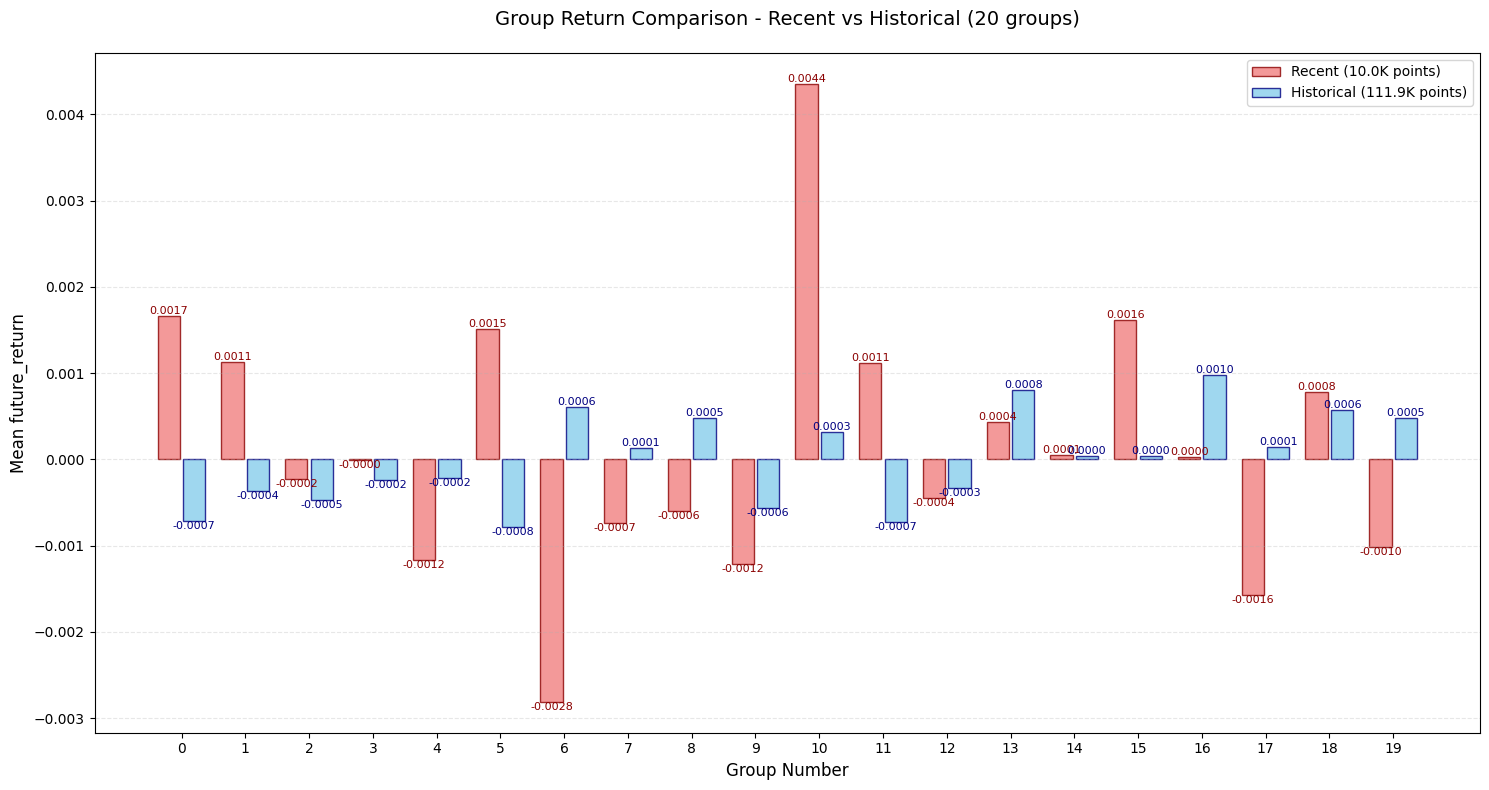

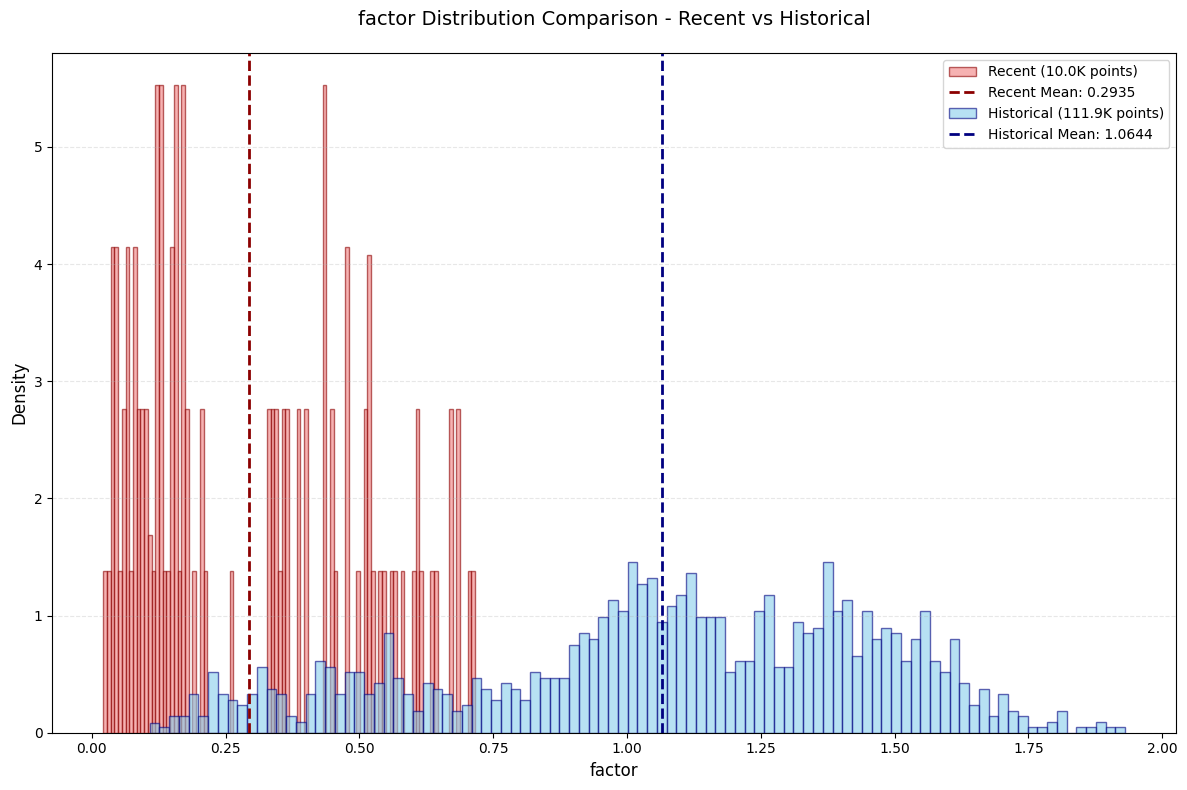

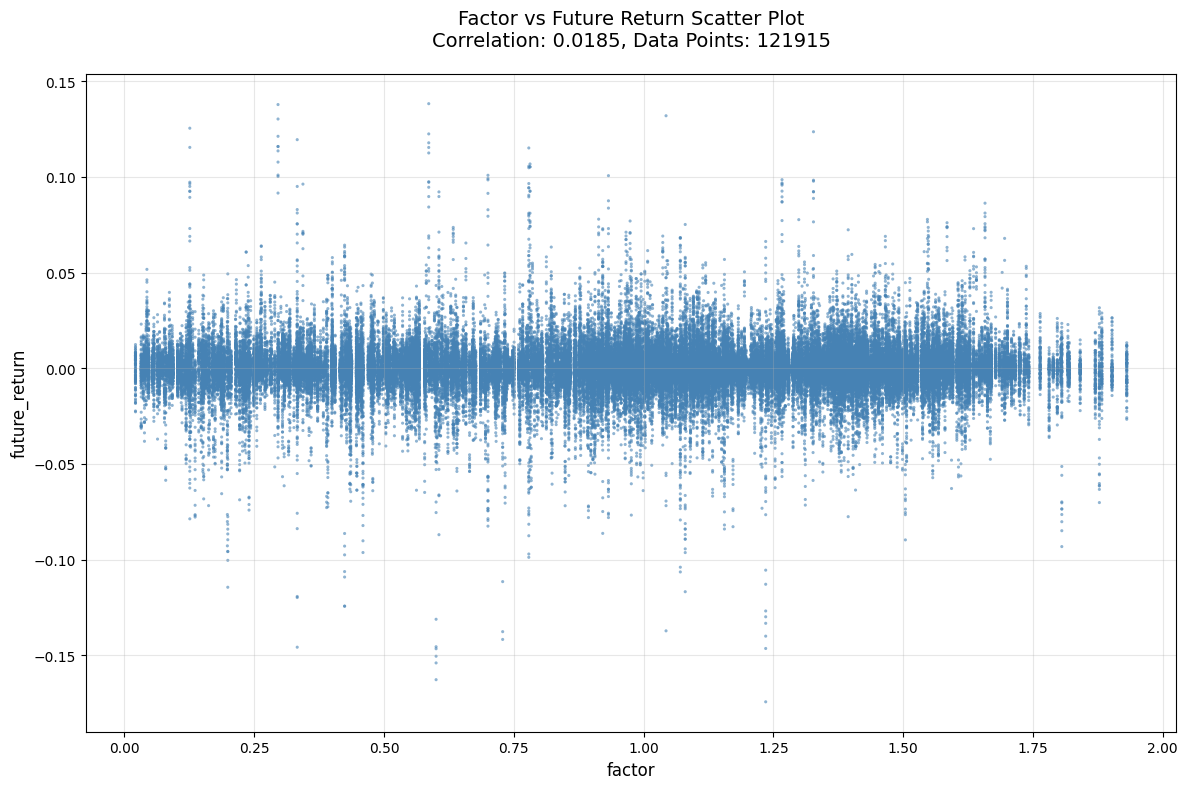

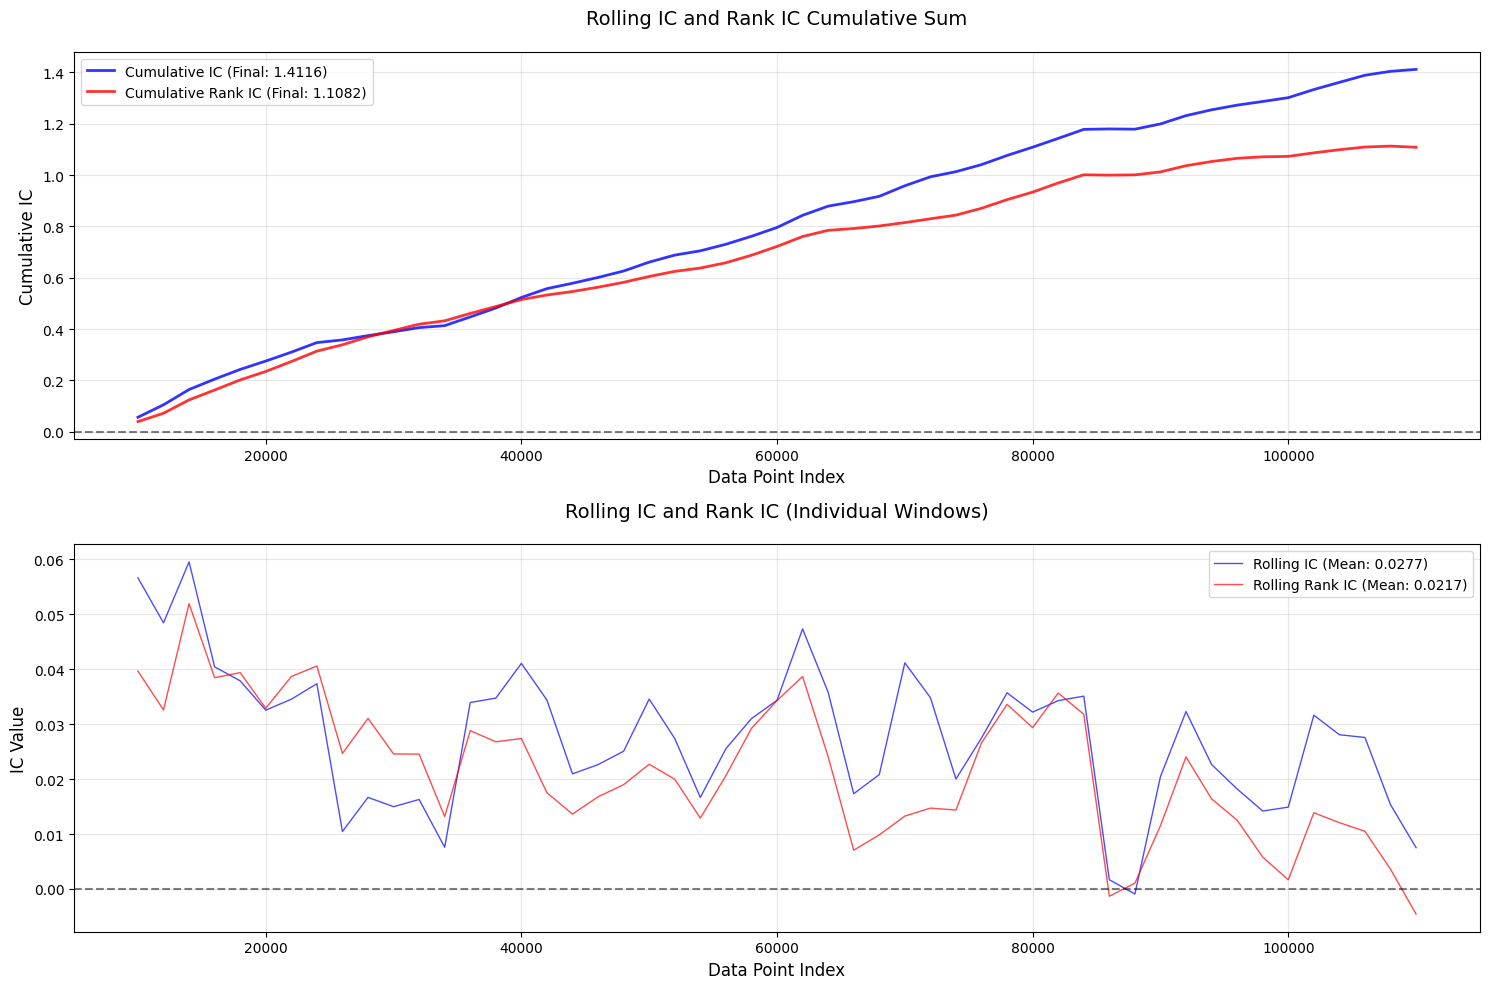

‚úÖ Â∑≤ÊòæÁ§∫ 4 ‰∏™ÂõæÁâá
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [6]:
result['information_ratio']['group_correlations']
# ËøôË°®Á§∫‰∏çÂêåÂàÜÁªÑ‰πãÈó¥ÁöÑÁõ∏ÂÖ≥ÊÄßÔºåÈÄöÂ∏∏Áî®‰∫éËØÑ‰º∞Âõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãÁöÑË°®Áé∞‰∏ÄËá¥ÊÄß„ÄÇ
# Â¶ÇÊûúÁõ∏ÂÖ≥ÊÄßËæÉÈ´òÔºåËØ¥ÊòéÂõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãË°®Áé∞‰∏ÄËá¥ÔºõÂ¶ÇÊûúÁõ∏ÂÖ≥ÊÄßËæÉ‰ΩéÔºåËØ¥ÊòéÂõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãË°®Áé∞Â∑ÆÂºÇËæÉÂ§ß„ÄÇ

[0.02538951109625784,
 -0.01597006752932641,
 -0.0192096665800563,
 0.015585759258553905,
 -0.004253697612415529,
 -0.00494894164727868,
 0.029371152625136145,
 -0.025106836844005494,
 -0.007596614505559869,
 -0.04145066487702969]

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.018549965417717133, 'Rank_IC': 0.011473632272693008}, 'information_ratio': {'IR': -0.22491140735781626, 'group_correlations': [0.02538951109625784, -0.01597006752932641, -0.0192096665800563, 0.015585759258553905, -0.004253697612415529, -0.00494894164727868, 0.029371152625136145, -0.025106836844005494, -0.007596614505559869, -0.04145066487702969], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.0212   0.1904    0.1183      -0.0004      0.0126   6144
1       0.1912   0.3336    0.2685       0.0002      0.0142   6144
2       0.3344   0.4516    0.3980      -0.0004      0.0129   6048
3       0.4516   0.5492    0.5002      -0.0003      0.0101   6235
4       0.5492   0.6530    0.5948       0.0002      0.0140   5952
5       0.6554   0.8025    0.7293      -0.0009      0.0150   6144
6       0.8033   0.9111    0.8634     